### This notebook is used to generate visualisation of images in this hives

In [1]:
# Bunch of imports
import pandas as pd
import sys, os, cv2
from datetime import datetime, timezone
import matplotlib.pyplot as plt
sys.path.append('Preprocessing')
sys.path.append('ForegroundRemoval/MedianFilter')
sys.path.append('ForegroundRemoval/PercentileFilter')
sys.path.append('VideoManagment')
from Preprocessing.preproc import beautify_frame
from VideoManagment.videolib import imageHiveOverview
from libimage import fetchImagesPaths
from ForegroundRemoval.PercentileFilter.percentile import percentile_filter_df

# Ignore FutureWarnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Configuration

In [2]:
# Get the latest picture of the hive specified. Last common picture taken by all cameras
hive = 1
data_folder = "/Users/cyrilmonette/Library/CloudStorage/SynologyDrive-data/25.07_aSensing_OH/Images/"
use_latest = True  # If True, use the latest picture, otherwise use the date specified below
remove_bees = True  # If True, remove bees from the image
if not use_latest:
    dt = pd.Timestamp("2024-10-28 10:50:00").tz_localize('UTC')

## Main script

Latest common image time: 2025-07-22 08:40:02+00:00


Fetching images: 100%|██████████| 1/1 [00:00<00:00, 135.37it/s]

Missing images before filtering:  0 out of 4 images.
Indexes:  [3071]
for images in folder:  /Users/cyrilmonette/Library/CloudStorage/SynologyDrive-data/25.07_aSensing_OH/Images/h1r1_5minutes
Dask images:  dask.array<_map_read_frame, shape=(3072, 2592, 4608, 3), dtype=uint8, chunksize=(1, 2592, 4608, 3), chunktype=numpy.ndarray>


Image dimensions:  2592 4608
Indexes:  [3071]
for images in folder:  /Users/cyrilmonette/Library/CloudStorage/SynologyDrive-data/25.07_aSensing_OH/Images/h1r2_5minutes
Dask images:  dask.array<_map_read_frame, shape=(3072, 2592, 4608, 3), dtype=uint8, chunksize=(1, 2592, 4608, 3), chunktype=numpy.ndarray>
Image dimensions:  2592 4608
Indexes:  [3071]
for images in folder:  /Users/cyrilmonette/Library/CloudStorage/SynologyDrive-data/25.07_aSensing_OH/Images/h1r3_5minutes
Dask images:  dask.array<_map_read_frame, shape=(3072, 2592, 4608, 3), dtype=uint8, chunksize=(1, 2592, 4608, 3), chunktype=numpy.ndarray>
Image dimensions:  2592 4608
Indexes:  [3072]
for images in folder:  /Users/cyrilmonette/Library/CloudStorage/SynologyDrive-data/25.07_aSensing_OH/Images/h1r4_5minutes
Dask images:  dask.array<_map_read_frame, shape=(3073, 2592, 4608, 3), dtype=uint8, chunksize=(1, 2592, 4608, 3), chunktype=numpy.ndarray>
Image dimensions:  2592 4608


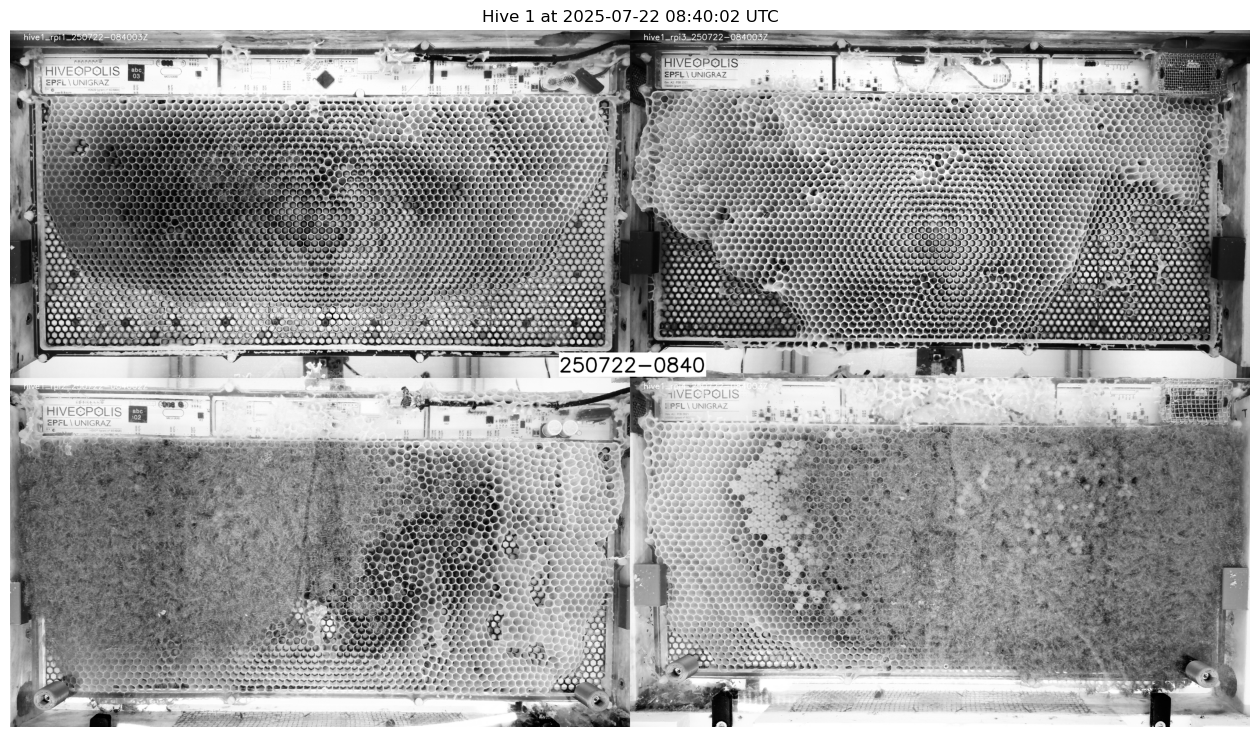

In [3]:
# Within the subfolders, find those that have the hive number
subfolders = [f for f in os.listdir(data_folder) if "h"+str(hive)+"r" in f]
subfolders.sort()

if use_latest:
    # Within those subfolders, find the last image taken commom to all cameras based on filename
    # Initialize a dictionary to store the latest image time for each subfolder
    latest_images = {}
    for subfolder in subfolders:
        images = [f for f in os.listdir(data_folder + subfolder) if f.endswith('.jpg')]
        for image in images:
            image_time = str(image.split('_')[-1].split('.')[0])
            naive_dt = datetime.strptime(image_time, "%y%m%d-%H%M%SZ")
            aware_dt = naive_dt.replace(tzinfo=timezone.utc)
            if subfolder not in latest_images or aware_dt.timestamp() > latest_images[subfolder].timestamp():
                latest_images[subfolder] = aware_dt

    # Find the latest common image time
    latest_common_time = min(latest_images.values())
    print("Latest common image time:", latest_common_time)
    timestamp = latest_common_time

else:
    # Use the specified date
    timestamp = dt

imgs_paths = fetchImagesPaths(data_folder, [timestamp], str(hive), images_fill_limit=1)

if remove_bees:
    row = imgs_paths.iloc[0].copy()
    row = pd.DataFrame(row).T # This converts the row to a DataFrame with a single row
    images, names = percentile_filter_df(row, percentile=90, filter_length=20, frame_skip=5, annotate_names=False, verbose=True)
    composed_img = imageHiveOverview(images.iloc[0].to_list(), names.iloc[0].to_list())

else:
    # Read images with cv2.imread from images paths and store in a list
    images = [cv2.imread(path, cv2.IMREAD_GRAYSCALE) for path in imgs_paths.iloc[0].tolist()]
    images = [beautify_frame(image) for image in images]
    imgs_names = [f.split('/')[-1] for f in imgs_paths.iloc[0].tolist()]
    imgs_names = [name.replace('.jpg', '') for name in imgs_names]
    composed_img = imageHiveOverview(images, imgs_names)

plt.figure(figsize=(16,12))
plt.imshow(composed_img, cmap='gray')
plt.axis('off')
plt.title("Hive " + str(hive) + " at " + timestamp.strftime("%Y-%m-%d %H:%M:%S") + " UTC")
plt.show()